In [1]:
# Import packages and set working directory if needed here
import datetime
import glob
import os

import tempfile
import warnings

# Hide the annoying future warnings from the earthpy spatial package
warnings.simplefilter(action='ignore', category=FutureWarning)

import earthpy.spatial as es
import geopandas as gpds
import numpy as np
import numpy.ma as ma
from rasterio import mask
import rasterio as rio
import rasterio.plot
from shapely.ops import transform

import common_functions

landsat_file_root = os.path.join(common_functions.HOME_DIR, 'original', 'landsat_summer')
landsat_inventory = {'landsat_7':
                        {'2016': [],
                         '2017': []},
                    'landsat_8': 
                        {'2016': ['LC080380322016060101T1-SC20181113111333',
                                 'LC080380322016061701T1-SC20181113111409',
                                 'LC080380322016070301T1-SC20181113111356',
                                 'LC080380322016082001T1-SC20181113111409'],
                        '2017': ['LC080380322017062001T1-SC20181113111351',
                                 'LC080380322017072201T1-SC20181113111417']}
                    }



def multi_to_single_layer(layer_list):
    """
    Convert multiple tif files stacked into a single layer.  This function is a wrapper around 
    es.stack_raster_tifs and extracts additional information (like the CRS, bounds and metadata) 
    from the output of this function.
    
    Parameters
    ----------
    layer_list: list of str
        A list off paths where the input layers are located
    
    Returns
    ----------
    stack_data: 3-d ndarray
        A 3-d numpy array with the first axis representing each band and the other two axes representing the 
        spatial dimensions of the data.
    stack_bounds: list
        A box representing the bounds of the output data.  These are in the order left-right-bottom-top.
    stack_crs: str
        The proj4 string representation of the CRS for the input files.
    stack_res: tuple
        A tuple of floats indicating the meters per pixel in the x and y directions.
    """
    with tempfile.TemporaryDirectory() as tmp:
        
        # stack_raster_tifs does return the data and some metadata for us but
        # we'll have to open the file to get our plotting bounds extent. 
        file_target = os.path.join(tmp, 'tmp.tif')
        stack_data, stack_meta = es.stack_raster_tifs(layer_list, file_target)
        stack_crs = stack_meta['crs']
        with rio.open(file_target) as src:
            stack_bounds = rasterio.plot.plotting_extent(src)
            stack_res = src.res
            
    return stack_data, stack_bounds, stack_crs, stack_res


def mask_clouds(qa_arr, landsat_ver="landsat_8"):
    """
    Creates a cloud mask given a qa_raster.
    
    Parameters
    ----------
    qa_arr: ndarray
        A qa raster containing information about cloud cover.
    landsat_ver: str
        A string representation of the landsat version.
        
    Returns
    ----------
    cloud_mask: ndarray
        A boolean array the same shape as qa_raster containing 
        True values where clouds are present and False values 
        where there are no clouds.
    """    
    if landsat_ver == "landsat_8":
        # Much of the terrain was being marked as cloud with the cloud_shadow and cloud 
        # mask values, so had to only mask high confidence clouds.
        cloud_shadow = []#[328, 392, 840, 904, 1350]
        cloud = []#[352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
        high_confidence_cloud = [480, 992]
        all_masked_values = np.array(cloud_shadow + cloud + high_confidence_cloud)
    # TODO: add landsat 7 cloud mask values here
    else:
        print("Landsat version %d not recognized.  No cloud removal performed." % landsat_ver)
    
    # Create a mask with True values indicating non-cloud pixels
    cloud_mask = np.isin(qa_arr, all_masked_values)
    
    return cloud_mask


def files_from_pattern(pattern, expect_single_file=False):
    """
    From a given pattern, retrieve the filenames.  If expect_single_file is True,
    raise an error if multiple files are returned.  If no files are returned, print
    a message.
    
    TODO: expand pattern to regex instead of only wildcards.
    
    Parameters
    ----------
    pattern: str
        A pattern to match filename.  At this time, only wildcards are accepted (no regular
        expressions).
    expect_single_file: bool
        When True, a valueError is raised if more than one file is returned.
    
    Returns
    ----------
    [file names]: list
        A list of returned file names.
    """
    returned_files = glob.glob(pattern)
    if len(returned_files) == 0:
        print("No files found for pattern %s." % pattern)
    if expect_single_file and len(returned_files) > 1:
        raise ValueError("Expecting a single value to be returned "
                         "and found %d values for pattern %s." 
                         % (len(returned_files), pattern))
    return returned_files

No files found for landsat type landsat_7 and year 2016
No files found for landsat type landsat_7 and year 2017


C:\Users\mdorf\Documents\earth-data-analytics\earth-analytics\avalanche-path-mapping\common_functions.py:53: RuntimeWarning: invalid value encountered in true_divide
  return (data[nir_idx] - data[red_idx]) / (data[nir_idx] + data[red_idx])


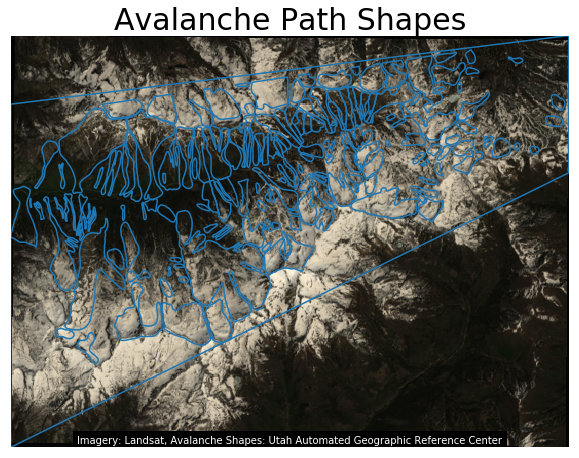

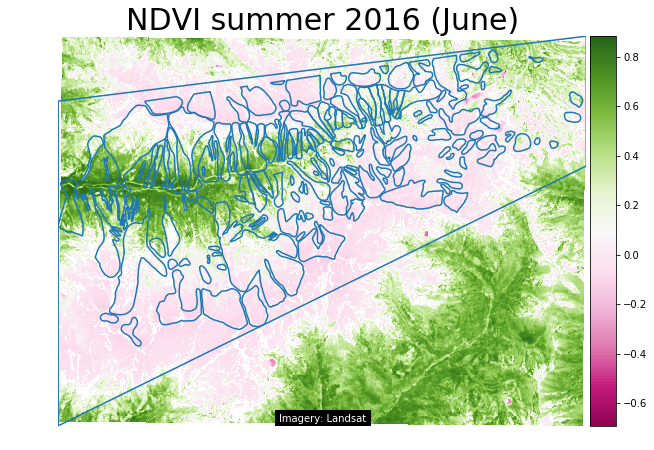

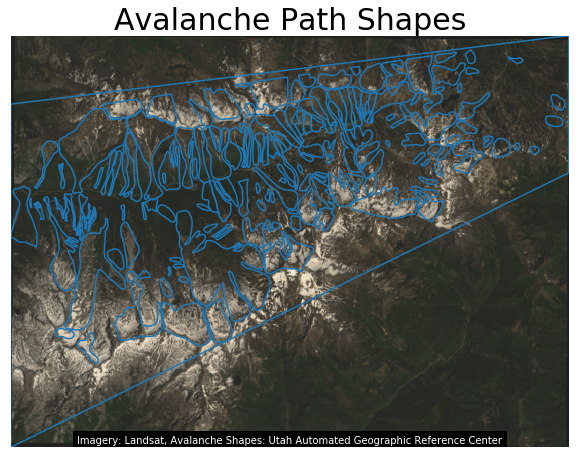

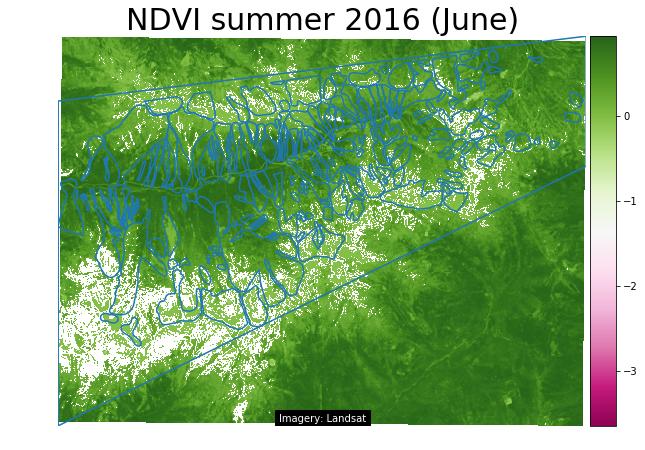

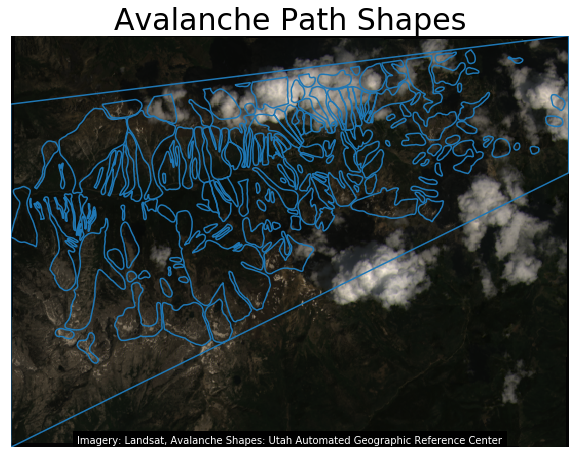

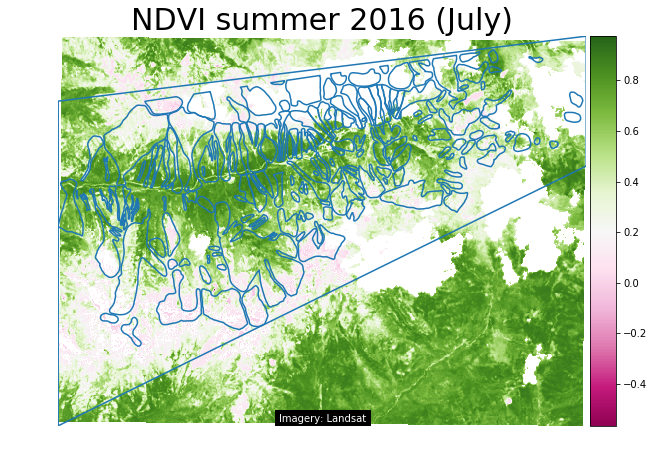

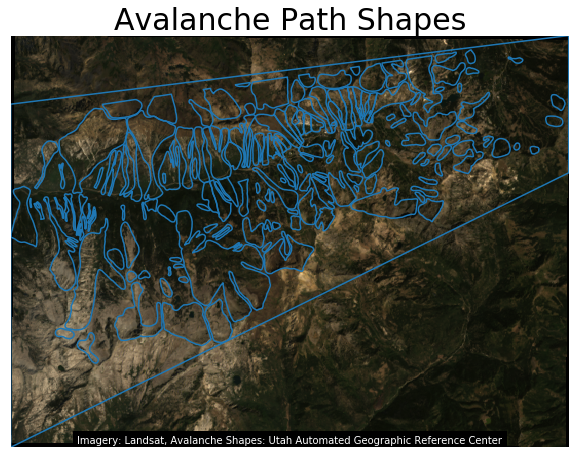

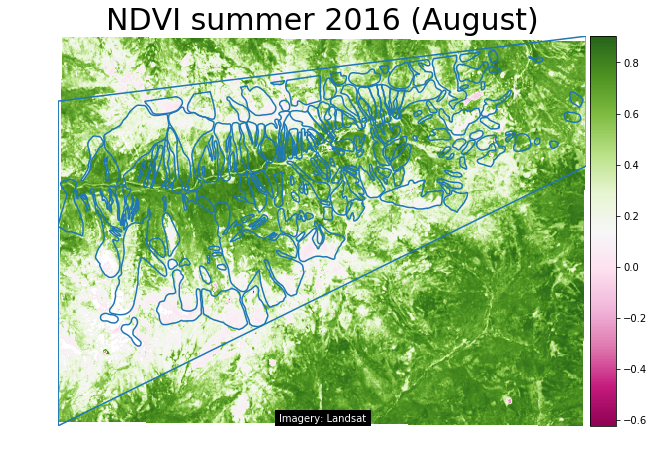

C:\Users\mdorf\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


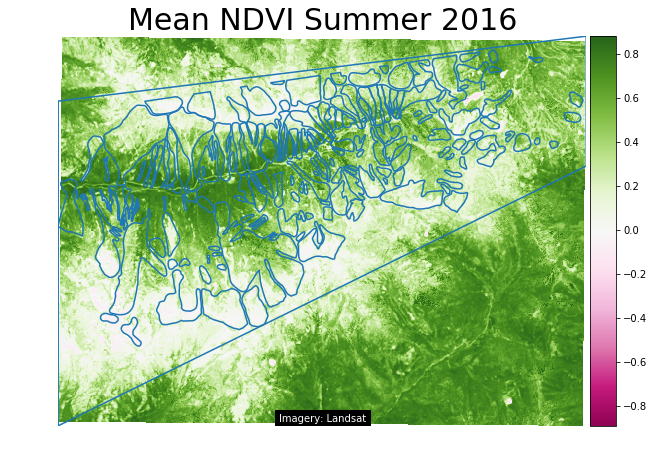

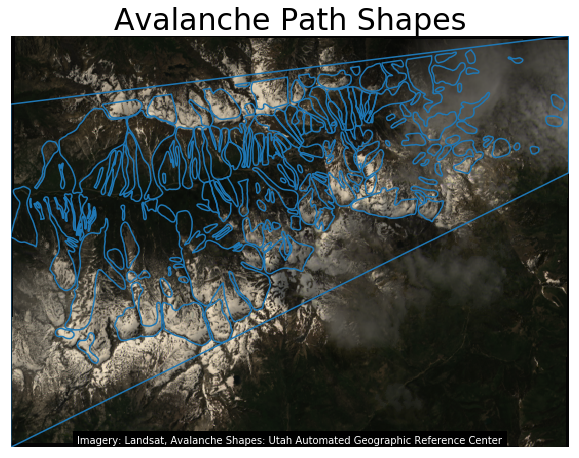

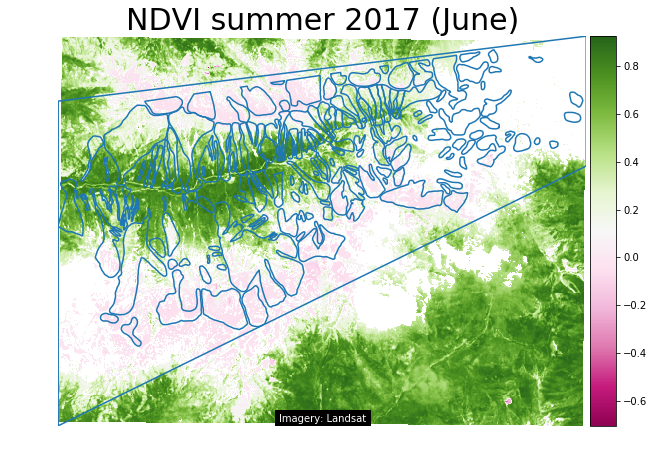

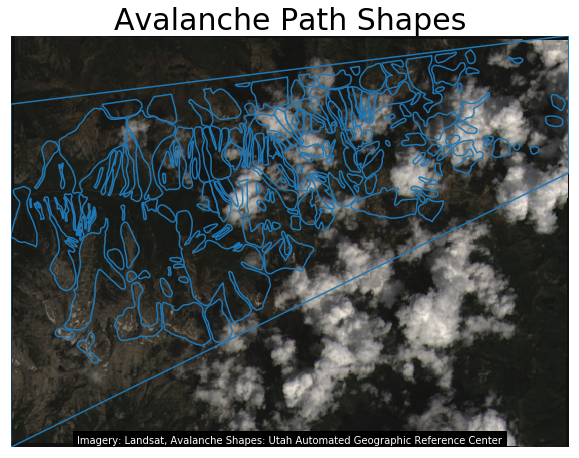

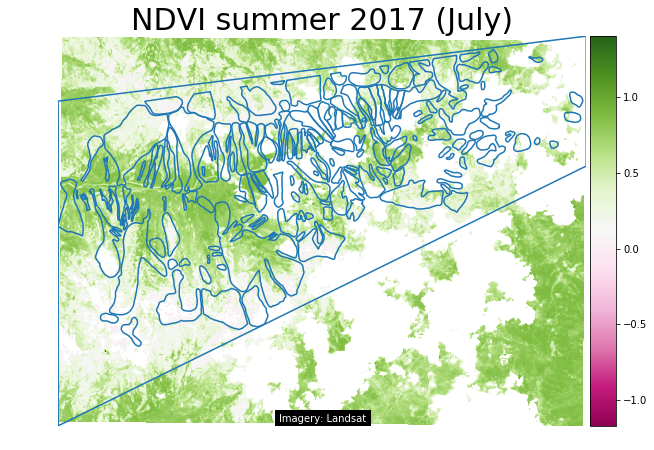

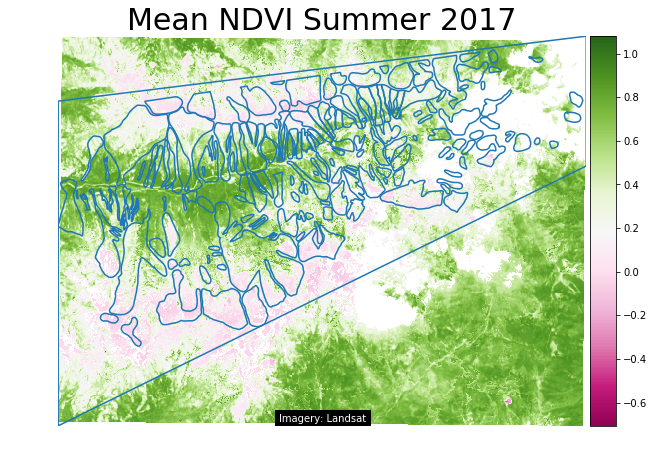

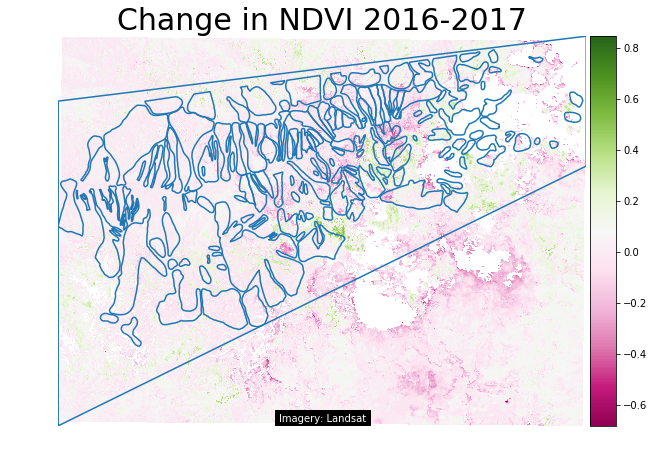

In [2]:
# Import, stack landsat pre-fire data  
landsat_path_list = ['LC080380322016060101T1-SC20181113111333',
'LC080380322016061701T1-SC20181113111409',
'LC080380322016070301T1-SC20181113111356',
'LC080380322016082001T1-SC20181113111409',
'LC080380322017062001T1-SC20181113111351',
'LC080380322017072201T1-SC20181113111417']

# This should match the qa layer
qa_match = 'pixel_qa'

# The order which we will be concatenating our tifs
color_order = ['red', 'green', 'blue', 'nir']

mean_ndvi_list = []

# Crop all data
for landsat_name, years_present in landsat_inventory.items():
    if landsat_name == 'landsat_7':
        band_colors = {
            'blue': 'band1',
            'green': 'band2',
            'red': 'band3',
            'nir': 'band4'
        }
    elif landsat_name == 'landsat_8':
        # This is a dictionary which matches patterns for each of the filenames
        band_colors = {
            'blue': 'band2',
            'green': 'band3',
            'red': 'band4',
            'nir': 'band5'
        }
    else:
        raise ValueError("Unknown name %s" % landsat_name)
    for year, file_list in years_present.items():
        if not file_list:
            print("No files found for landsat type %s and year %s" % (landsat_name, year))
            continue
        accumulated_ndvi_arrays = []
        for file in file_list:
            accumulated_bands_list = []
            accumulated_bands_list_unmasked = []
            full_path = os.path.join(landsat_file_root, landsat_name, year, file)            
            
            # Get QA layer to create our cloud mask
            qa_file_name = files_from_pattern(os.path.join(full_path, "*%s*" % qa_match), 
                                                 expect_single_file=True)[0]
            with rasterio.open(qa_file_name) as src:
                # Reproject our shape to whatever projection the landsat data is in
                landsat_crs = src.crs.to_dict()
                study_area_box_reprojected = common_functions.study_area_box_gdf.to_crs(landsat_crs)
                qa_arr, _ = mask.mask(src, study_area_box_reprojected.geometry, crop=True)
                qa_arr = np.squeeze(qa_arr)

                cloud_mask = mask_clouds(qa_arr, landsat_ver=landsat_name)

            # Loop through the colors necessary to create NDVI
            for color in color_order:
                band_file_name = files_from_pattern(os.path.join(full_path, "*%s*" % band_colors[color]), 
                                                    expect_single_file=True)[0]
                with rasterio.open(band_file_name) as src:
                    # Reproject our shape to whatever projection the landsat data is in
                    masked_band, _ = mask.mask(src, study_area_box_reprojected.geometry, crop=True)
                    masked_band = np.squeeze(masked_band)
                    
                    # Mask invalid values
                    masked_band[masked_band == -9999] = ma.masked
                    
                    # Save unmasked image
                    accumulated_bands_list_unmasked.append(masked_band.copy())
                    
                    # Mask clouds                    
                    masked_band[cloud_mask] = ma.masked                    
                    accumulated_bands_list.append(masked_band)          

            accumulated_bands_arr = np.array(accumulated_bands_list)
            accumulated_bands_arr_unmasked = np.array(accumulated_bands_list_unmasked)
            ndvi_arr = common_functions.calculate_NDVI(accumulated_bands_arr)
            accumulated_ndvi_arrays.append(ndvi_arr)
          
            common_functions.plot_array_and_vector(accumulated_bands_arr_unmasked, 
                                                   landsat_crs,
                                                   "Avalanche Path Shapes", 
                                                   "Imagery: Landsat, Avalanche Shapes: Utah Automated Geographic Reference Center")
            
            month_datetime = datetime.datetime.strptime(file[14:16], '%m')
            common_functions.plot_array_and_vector(ndvi_arr, 
                                                   landsat_crs,
                                                   "NDVI summer %s (%s)" % (year, month_datetime.strftime('%B')), 
                                                   "Imagery: Landsat")
            
        if accumulated_ndvi_arrays:
            accumulated_ndvi_arrays_stacked = np.array(accumulated_ndvi_arrays)
            annual_mean_ndvi = np.nanmean(accumulated_ndvi_arrays_stacked, axis=0)
            mean_ndvi_list.append(annual_mean_ndvi)
            
            month_datetime = datetime.datetime.strptime(file[14:16], '%m')
            common_functions.plot_array_and_vector(annual_mean_ndvi, 
                                                   landsat_crs,
                                                   "Mean NDVI Summer %s" % (year), 
                                                   "Imagery: Landsat",
                                                   fname='NDVI %s' % year)
            
dndvi = mean_ndvi_list[1] - mean_ndvi_list[0]

_ = common_functions.plot_array_and_vector(dndvi, 
                                           landsat_crs,
                                           "Change in NDVI 2016-2017", 
                                           "Imagery: Landsat", 
                                           fname='dNDVI.jpg')
